In [ ]:
from typing import Type, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output, display
from ipywidgets import Output
from torch import nn, optim
from tqdm.auto import trange
from google.colab.patches import cv2_imshow
import random

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, GaussianBlur, RandomApply, ColorJitter, Grayscale, ToPILImage
from PIL import Image, ImageOps
import glob
import cv2

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r '/content/content'

In [ ]:
!unzip -q "/content/drive/MyDrive/Documents/Results.zip"

In [ ]:
!mkdir Blures_pages

In [ ]:
!rm -r '/content/Blures_pages'

In [ ]:
pages_pathes = glob.glob('/content/content/Results/*')
rand_sigma = [0.5, 0.6, 0.7]

for i, path in enumerate(pages_pathes):
  image = Image.open(path)
  random_blur = random.choice(rand_sigma)
  blur = GaussianBlur(kernel_size=(7, 7), sigma = (random_blur, random_blur))
  image = blur(image)
  name = path.split('/')[-1]
  image.save(f'/content/Blures_pages/{name}')

In [ ]:
!mkdir Samples

In [ ]:
!mkdir Samples_blured

In [ ]:
!rm -r '/content/Samples'
!rm -r '/content/Samples_blured'

rm: cannot remove '/content/Samples': No such file or directory
rm: cannot remove '/content/Samples_blured': No such file or directory


In [ ]:
for k in range(500):
  image_x = cv2.imread(f'/content/content/Results/result{k}.jpg')
  image_y = cv2.imread(f'/content/Blures_pages/result{k}.jpg')

  for i in range(8):
    for j in range(8):
      cv2.imwrite(f'/content/Samples/sample_{k}_{i}_{j}.jpg', image_x[i * 160 : (i + 1) * 160, i * 115 : (i + 1) * 115])
      cv2.imwrite(f'/content/Samples_blured/sample_{k}_{i}_{j}.jpg', image_y[i * 160 : (i + 1) * 160, i * 115 : (i + 1) * 115])

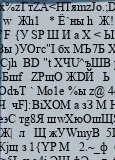

In [ ]:
image_show = cv2.imread('/content/Samples/sample_21_0_0.jpg')
cv2_imshow(image_show)

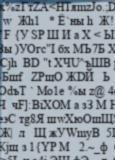

In [ ]:
image_show = cv2.imread('/content/Samples_blured/sample_21_0_0.jpg')
cv2_imshow(image_show)

In [ ]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), padding = 0),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        return z


class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = (3,3), stride = 2, padding = 0),
            nn.Sigmoid()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        reconstructed_x = self.decoder(z)

        return reconstructed_x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        encoder_class: Type[Encoder] = Encoder,
        decoder_class: Type[Decoder] = Decoder,
        criterion_class: Type[torch.optim.Optimizer] = nn.MSELoss,
    ) -> None:
        super().__init__()

        self.enc = encoder_class()
        self.dec = decoder_class()
        self.criterion = criterion_class()

    def forward(self, x):
      z = self.enc(x)
      return self.dec(z)

In [ ]:
def train_epoch(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    device: torch.device = "cuda",
    conditional: bool = False,
) -> list[float]:
    model.to(device)
    model.train()
    epoch_loss_trace = []

    for i, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

    return epoch_loss_trace


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion,
    scheduler,
    num_epochs: int = 20,
    device: torch.device = "cuda",
    conditional: bool = False,
) -> None:
    loss_trace = []
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True):
        epoch_loss_trace = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            criterion = criterion,
            optimizer=optimizer,
            device=device,
            conditional=conditional,
        )
        scheduler.step()

        loss_trace += epoch_loss_trace

    plt.figure(figsize=(10, 5))
    plt.title("Total training loss", fontsize=22)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Reconstruction loss", fontsize=16)
    plt.grid()
    plt.plot(loss_trace)
    plt.show()

    model.eval()

In [ ]:
class DocDataset(Dataset):
  def __init__(self, transform=None, augment=None):
    self.transform = transform
    self.augment = augment
    self.images_files_train = glob.glob('/content/Samples/*')[:750]  

  def __len__(self):
    return len(self.images_files_train)

  def __getitem__(self, idx):
    image_train = Image.open(self.images_files_train[idx].replace('Samples', 'Samples_blured')).convert('RGB')
    image_train_cleaned = Image.open(self.images_files_train[idx]).convert('RGB')

    return (self.augment(image_train), self.transform(image_train_cleaned))

In [ ]:
transform = transforms.Compose([Resize(size = (255, 255)), Grayscale(), ToTensor()])
augment = transforms.Compose([Resize(size = (255, 255)), Grayscale(), ToTensor()])
dataset = DocDataset(transform, augment)
train_dataloader_with_noise = DataLoader(dataset, batch_size = 1, shuffle = True)

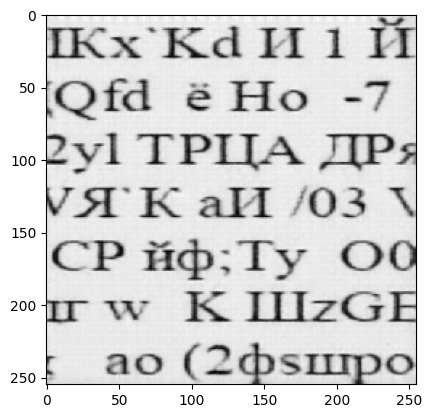

In [ ]:
out = 0
#model_for_noise = AutoEncoder()
#model_for_noise.load_state_dict(torch.load('model.pth'))
with torch.no_grad():
  for x, y in train_dataloader_with_noise:
    out = model_for_noise(x.to(device))
    plt.imshow(out.detach().to('cpu').squeeze().permute(0, 1), cmap='gray')
    break

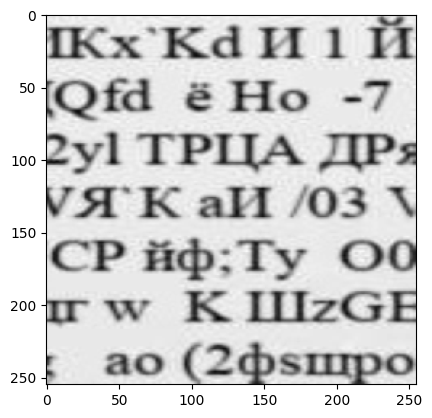

In [ ]:
plt.imshow(x.detach().to('cpu').squeeze().permute(0, 1), cmap='gray')

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

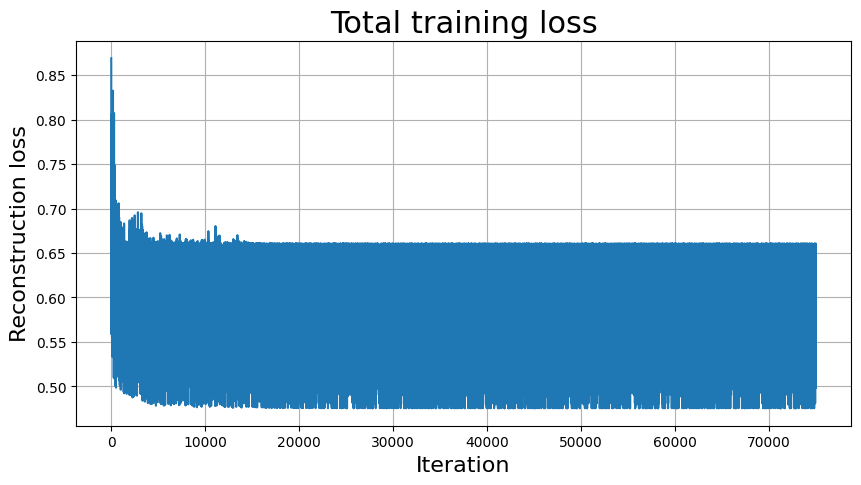

In [ ]:
# обучим автоэнкодер на зашумленных данных
from torch.optim.lr_scheduler import StepLR
model_for_noise = AutoEncoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model_for_noise.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
train_model(model_for_noise, train_dataloader_with_noise, optimizer, criterion, scheduler, num_epochs = 100, device=device)

In [ ]:
torch.save(model_for_noise.state_dict(), 'model.pth')

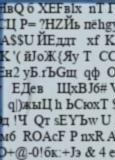

In [ ]:
image_to_denoise = cv2.imread('/content/Samples_blured/sample_0_0_0.jpg')
img = cv2.cvtColor(image_to_denoise, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
im_pil.show()

In [ ]:
model_for_noise = model_for_noise.eval()
model_for_noise.to('cpu')
image_to_denoise = cv2.imread('/content/Samples_blured/sample_0_0_0.jpg')
img = cv2.cvtColor(image_to_denoise, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
test_x = transform(im_pil)
test_y = model_for_noise(x)

In [ ]:
test_y.shape

torch.Size([1, 1, 255, 255])

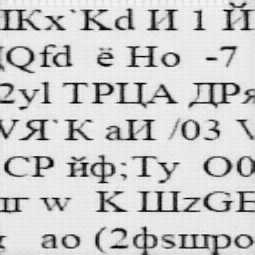

In [ ]:
output_array = test_y.detach().cpu().numpy()

output_array = output_array.squeeze()
output_array = (output_array - output_array.min()) / (output_array.max() - output_array.min()) * 255.0
output_array = output_array.astype(np.uint8)

output_image = cv2.cvtColor(output_array, cv2.COLOR_GRAY2BGR)

cv2.imwrite("output_image.jpg", output_image)
cv2_imshow(output_image)

In [ ]:
class ConvGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = (3,3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = (3,3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = (3,3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(128, 256, kernel_size = (3,3), padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.ConvTranspose2d(256, 128, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = (3,3), stride = 2, padding = 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.seq(x)
        return x


class ConvDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4, 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 1, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(in_features=225, out_features=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        for p in self.parameters():
          p.data.clamp_(-0.01, 0.01)
        x = self.seq(x)
        return x

In [ ]:
# Calculate losses
def real_loss(D_out):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
lr = 1e-3
D = ConvDiscriminator()
G = ConvGenerator()
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)
transform = transforms.Compose([Resize(size = (255, 255)), Grayscale(), ToTensor()])
augment = transforms.Compose([Resize(size = (255, 255)), Grayscale(), ToTensor()])
dataset = DocDataset(transform, augment)
train_dataloader_with_noise = DataLoader(dataset, batch_size = 40, shuffle = True)

In [ ]:
D.train()
G.train()
D.to(device)
G.to(device)
n_critic = 5
num_epochs = 5
for epoch in trange(num_epochs, desc="Epoch: ", leave=True):
    for batch_i, (x, y) in enumerate(train_dataloader_with_noise):
      x = x.to(device)
      y = y.to(device)
      fake_images = G(x)
      fake_image_score = D(fake_images)
      real_object_score = D(y)

      if (batch_i % (n_critic + 1)) == 0:
        g_optimizer.zero_grad()
        gen_loss = - fake_loss(fake_image_score)
        gen_loss.backward()
        g_optimizer.step()
      else:
        d_optimizer.zero_grad()
        discr_loss = fake_loss(fake_image_score) - real_loss(real_object_score)
        discr_loss.backward()
        d_optimizer.step()
    print(f'Generator loss: {gen_loss}, desc loss: {discr_loss}')

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Generator loss: -0.9710884094238281, desc loss: 0.4952038526535034
Generator loss: -0.971103310585022, desc loss: 0.4951896369457245
Generator loss: -0.9710956811904907, desc loss: 0.4951664209365845
Generator loss: -0.9710983633995056, desc loss: 0.49518558382987976
Generator loss: -0.9711068272590637, desc loss: 0.49518027901649475


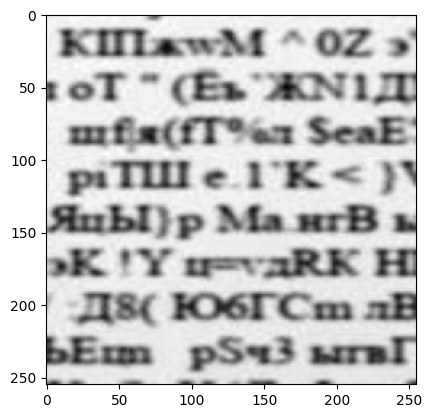

In [ ]:
G.train(False)
out = 0
with torch.no_grad():
  for x, y in train_dataloader_with_noise:
    out = G(x.to(device))
    plt.imshow(x.detach().to('cpu').squeeze().permute(0, 1), cmap='gray')
    break

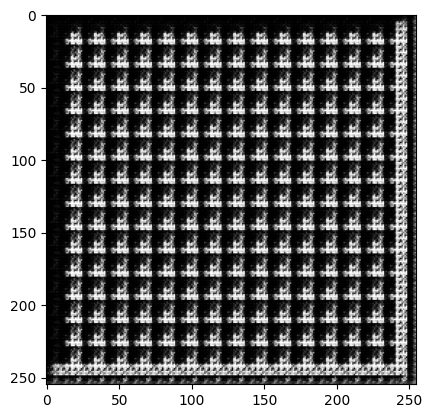

In [ ]:
plt.imshow(out.detach().to('cpu').squeeze().permute(0, 1), cmap='gray')